In [24]:
# 자연어 처리 관련 모듈 ------------------------------------------------------------------------
import re
import numpy as np
import pandas as pd
import torch
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
from konlpy.tag import Okt, Komoran, Kkma


# 시각화 관련 모듈 -----------------------------------------------------------------------------
import matplotlib.pyplot as plt

In [25]:
tokenizer = Okt()

In [26]:
rawDF = pd.read_csv('../pronunciation_standard.txt', sep='\t')
rawDF.head(5)

,pronunciation,standard
0,오랫동안 한 동네에서 살았던 할무닌데 도라가주씨 매매 아프네요,오랫동안 한 동네에서 살았던 할머니인데 돌아가겨서 마음이 아프네요
1,혈압약은 시간을 맞춰 챙겨 드셔야지 안 그러면 효과가 없습니다,혈압약은 시간을 맞춰 챙겨 드셔야지 안 그러면 효과가 없습니다
2,집에 돌아와 보이꺼네 문이 열려 있고 뼈다지가 열어둔 돈 전부 없어지던 어이떼,집에 돌아와 보니까 문이 열려 있고 서랍이 열어둔 돈 전부 없어지던 어이떼
3,아들 오늘 중요한 시험 보니까네 이 생서 하고 사가꼬 묵고 힘내서 시험 잘 바래이,아들 오늘 중요한 시험 보니까 이 생 엿 하고 사서 먹고 힘내서 시험 잘 봐
4,옛날부터 조상꿈이나 돼지꿈 꾸만 집에 돈 많이 들어온다고 좋아 해찌로,옛날부터 조상꿈이나 돼지꿈 꾸면 집에 돈 많이 들어온다고 좋아 했죠


In [27]:
max_src_len = max( [len(line) for line in rawDF.pronunciation])
print(max_src_len)

70


In [28]:
def cleanTxt(sent):
	# 한글 공백 제외 삭제
	sent = re.sub(r"[^가-힣\s]", "", sent)
	return sent

In [29]:
def load_preprocessed_data(tokenizer):
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("../pronunciation_standard.txt", "r") as lines:
        
        for i, line in enumerate(lines):
            
            # source 데이터와 target 데이터 분리
            if not i: continue										# header 라인 패스
            elif len(line.strip().split('\t'))==2:
                
                # print(line.strip().split('\t'))					# ['혈압약은 시간을', '혈압약은 시간을']
                
				# 표준어 	방언
                src_line, tar_line = line.strip().split('\t')[1], line.strip().split('\t')[0]
	
				# source 데이터 전처리
                src_line = [w for w in tokenizer.morphs(cleanTxt(src_line))]
                # print(src_line)
                # break

				# target 데이터 전처리
                tar_line = tokenizer.morphs(cleanTxt(tar_line))
                tar_line_in = [w for w in (["<sos>"] + tar_line)]
                tar_line_out = [w for w in (tar_line + ["<eos>"])]

                encoder_input.append(src_line)
                decoder_input.append(tar_line_in)
                decoder_target.append(tar_line_out)
                

            # if i == len(lines) - 1:
            #     break

    return encoder_input, decoder_input, decoder_target

In [30]:
# tmp = "올해는
#  배치 농사를 망우가 짐장을 할라믄 배치를 좀 사와가 담구야 데겠네"	"올해는
#  배추 농사를 망쳐서 김장을 하려면 배추를 좀 사와서 담궈야 되겠네"

In [31]:
sents_std_in, sents_di_in, sents_di_out = load_preprocessed_data(tokenizer)
print('인코더의 입력 :',sents_std_in[:5])
print('디코더의 입력 :',sents_di_in[:5])
print('디코더의 레이블 :',sents_di_out[:5])

인코더의 입력 : [['오랫동안', '한', '동네', '에서', '살았던', '할머니', '인데', '돌아가', '겨', '서', '마음', '이', '아프네요'], ['혈압', '약', '은', '시간', '을', '맞춰', '챙겨', '드셔야지', '안', '그러면', '효과', '가', '없습니다'], ['집', '에', '돌아와', '보', '니까', '문', '이', '열려', '있고', '서랍', '이', '열어', '둔', '돈', '전부', '없어지던', '어이', '떼'], ['아들', '오늘', '중요한', '시험', '보', '니까', '이', '생', '엿', '하고', '사서', '먹고', '힘내서', '시험', '잘', '봐'], ['옛날', '부터', '조상', '꿈', '이나', '돼지', '꿈', '꾸면', '집', '에', '돈', '많이', '들어온다고', '좋아', '했죠']]
디코더의 입력 : [['<sos>', '오랫동안', '한', '동네', '에서', '살았던', '할무닌데', '도라', '가주', '씨', '매매', '아프네요'], ['<sos>', '혈압', '약', '은', '시간', '을', '맞춰', '챙겨', '드셔야지', '안', '그러면', '효과', '가', '없습니다'], ['<sos>', '집', '에', '돌아와', '보이', '꺼', '네', '문', '이', '열려', '있고', '뼈', '다지', '가', '열어', '둔', '돈', '전부', '없어지던', '어이', '떼'], ['<sos>', '아들', '오늘', '중요한', '시험', '보', '니까', '네', '이', '생', '서', '하고', '사가', '꼬', '묵고', '힘내서', '시험', '잘', '바', '래', '이'], ['<sos>', '옛날', '부터', '조상', '꿈', '이나', '돼지', '꿈', '꾸만', '집', '에', '돈', '많이', '들어온다고', '좋아', '해찌', '로']]
디코더의 레

In [32]:
set(sents_std_in[0])

{'겨',
 '돌아가',
 '동네',
 '마음',
 '살았던',
 '서',
 '아프네요',
 '에서',
 '오랫동안',
 '이',
 '인데',
 '한',
 '할머니'}

In [33]:
def build_vocab(sents):
  word_list = []

  for sent in sents:
      for word in sent:
        word_list.append(word)

  # 단어 중복 제거
  vocab = set(word_list)

  word_to_index = {}
  word_to_index['<PAD>'] = 0
  word_to_index['<UNK>'] = 1

  # 등장 빈도가 높은 단어일수록 낮은 정수를 부여
  for index, word in enumerate(vocab) :
    word_to_index[word] = index + 2

  return word_to_index


In [34]:
src_vocab = build_vocab(sents_std_in)
tar_vocab = build_vocab(sents_di_in + sents_di_out)

src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)
print("표준어 단어 집합의 크기 : {:d}, 방언 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

표준어 단어 집합의 크기 : 5027, 방언 단어 집합의 크기 : 9256


In [35]:
src_vocab

{'<PAD>': 0,
 '<UNK>': 1,
 '싶으': 2,
 '담': 3,
 '나오면은': 4,
 '이사': 5,
 '먹었다고': 6,
 '몰랐겠다': 7,
 '그리고': 8,
 '붙여야지': 9,
 '잤네': 10,
 '이번': 11,
 '이다': 12,
 '듭니': 13,
 '상낭': 14,
 '놀랐습니다': 15,
 '좋아질까': 16,
 '찹': 17,
 '뻐': 18,
 '구': 19,
 '했으니': 20,
 '커서': 21,
 '잤어': 22,
 '되지요': 23,
 '난대': 24,
 '맛있네': 25,
 '입으싰다': 26,
 '입었': 27,
 '납니다': 28,
 '한데요': 29,
 '바이': 30,
 '보니': 31,
 '못': 32,
 '돌아서면': 33,
 '없나': 34,
 '비비면서': 35,
 '먹이러': 36,
 '트랙': 37,
 '빼': 38,
 '고만': 39,
 '강': 40,
 '했는지': 41,
 '일꾼': 42,
 '먹을지': 43,
 '이바': 44,
 '가져': 45,
 '귤': 46,
 '보내면': 47,
 '바람벽': 48,
 '있잖아': 49,
 '동강': 50,
 '배추': 51,
 '않거든': 52,
 '먹겠습니다': 53,
 '나서': 54,
 '약간': 55,
 '오': 56,
 '밭뗴기': 57,
 '빌었습니다': 58,
 '없었으니': 59,
 '납답한': 60,
 '슬슬': 61,
 '바': 62,
 '있으니깐': 63,
 '높아가': 64,
 '되네': 65,
 '달아가': 66,
 '답': 67,
 '내딛어': 68,
 '당겨': 69,
 '총': 70,
 '도리': 71,
 '놓았으': 72,
 '끊어지는': 73,
 '사를': 74,
 '배채': 75,
 '하여간': 76,
 '진짜': 77,
 '미리': 78,
 '피우는': 79,
 '심어': 80,
 '걷기': 81,
 '재울이': 82,
 '참아요': 83,
 '착해': 84,
 '비고': 85,
 '하지로': 86,
 '됐데

In [36]:
index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

def texts_to_sequences(sents, word_to_index):
  encoded_X_data = []
  for sent in sents:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data


In [37]:
# 정수 인코딩딩
encoder_input = texts_to_sequences(sents_std_in, src_vocab)
decoder_input = texts_to_sequences(sents_di_in, tar_vocab)
decoder_target = texts_to_sequences(sents_di_out, tar_vocab)

In [38]:
# 상위 5개의 샘플에 대해서 정수 인코딩 전, 후 문장 출력
# 인코더 입력이므로 <sos>나 <eos>가 없음
for i, (item1, item2) in zip(range(5), zip(sents_std_in, encoder_input)):
    print(f"Index: {i},\n 정수 인코딩 전: {item1}, \n 정수 인코딩 후: {item2}")


Index: 0,
 정수 인코딩 전: ['오랫동안', '한', '동네', '에서', '살았던', '할머니', '인데', '돌아가', '겨', '서', '마음', '이', '아프네요'], 
 정수 인코딩 후: [342, 4719, 281, 3029, 3564, 1514, 1743, 1232, 4110, 2948, 1708, 1273, 1928]
Index: 1,
 정수 인코딩 전: ['혈압', '약', '은', '시간', '을', '맞춰', '챙겨', '드셔야지', '안', '그러면', '효과', '가', '없습니다'], 
 정수 인코딩 후: [864, 1878, 3553, 3156, 1777, 932, 2840, 3880, 4099, 4112, 2199, 2242, 2484]
Index: 2,
 정수 인코딩 전: ['집', '에', '돌아와', '보', '니까', '문', '이', '열려', '있고', '서랍', '이', '열어', '둔', '돈', '전부', '없어지던', '어이', '떼'], 
 정수 인코딩 후: [1645, 3185, 447, 3444, 3349, 3145, 1273, 183, 2660, 4424, 1273, 1236, 4921, 4029, 1553, 140, 1565, 2865]
Index: 3,
 정수 인코딩 전: ['아들', '오늘', '중요한', '시험', '보', '니까', '이', '생', '엿', '하고', '사서', '먹고', '힘내서', '시험', '잘', '봐'], 
 정수 인코딩 후: [674, 4274, 2009, 4715, 3444, 3349, 1273, 2598, 2480, 3359, 988, 1718, 2080, 4715, 1435, 1991]
Index: 4,
 정수 인코딩 전: ['옛날', '부터', '조상', '꿈', '이나', '돼지', '꿈', '꾸면', '집', '에', '돈', '많이', '들어온다고', '좋아', '했죠'], 
 정수 인코딩 후: [2037, 815, 962, 1672, 3378, 

In [39]:
def pad_sequences(sentences, max_len=None):
    # 최대 길이 값이 주어지지 않을 경우 데이터 내 최대 길이로 패딩
    if max_len is None:
        max_len = max([len(sentence) for sentence in sentences])

    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features


In [40]:
# 패딩
encoder_input = pad_sequences(encoder_input)
decoder_input = pad_sequences(decoder_input)
decoder_target = pad_sequences(decoder_target)

In [41]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (15296, 32)
디코더의 입력의 크기(shape) : (15296, 37)
디코더의 레이블의 크기(shape) : (15296, 37)


In [42]:
type( encoder_input )

numpy.ndarray

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

In [20]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
# 테스트 데이터를 분리하기 전 데이터를 섞어줍니다. 이를 위해서 순서가 섞인 정수 시퀀스 리스트를 만듭니다.
#  데이터셋의 순서로 지정해주면 샘플들이 기존 순서와 다른 순서로 섞이게 됩니다.

In [43]:
print(encoder_input[12300])
print(decoder_input[12300])
print(decoder_target[12300])
# 이때 decoder_input과 decoder_target은 데이터의 구조상으로 앞에 붙은 <sos> 토큰과 뒤에 붙은 <eos>을 제외하면 동일한 정수 시퀀스를 가져야 합니다.

[3602 3185 4289 1587 1373 3185  974 1233  368 3469 4983 2510 1378 3879
   28    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[6214 6591 5782 7896 2926 2538 5782 1776 2281  638 6338 9191 4632 2544
 7103 2451 5412    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
[6591 5782 7896 2926 2538 5782 1776 2281  638 6338 9191 4632 2544 7103
 2451 5412 3514    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


In [44]:
print([index_to_src[word] for word in encoder_input[12300]])
print([index_to_tar[word] for word in decoder_input[12300]])
print([index_to_tar[word] for word in decoder_target[12300]])


['뱀', '에', '몰리', '면', '병원', '에', '가야', '지', '된장', '같은', '거', '마음대로', '바르면', '큰일', '납니다', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<sos>', '뱀', '에', '몰리', '면', '병원', '에', '가야', '지', '된장', '같은', '거', '마음대로', '바르면', '큰일', '남니', '더', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['뱀', '에', '몰리', '면', '병원', '에', '가야', '지', '된장', '같은', '거', '마음대로', '바르면', '큰일', '남니', '더', '<eos>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [45]:
n_of_train = int(15296*0.7) +1
n_of_val = int(15296*0.2)
n_of_test = int(15296*0.1)


print('훈련 데이터의 개수 :',n_of_train)
print('검증 데이터의 개수 :',n_of_val)
print('테스트 데이터의 개수 :',n_of_test)

print("총합",n_of_train+n_of_val+n_of_test)

훈련 데이터의 개수 : 10708
검증 데이터의 개수 : 3059
테스트 데이터의 개수 : 1529
총합 15296


In [46]:
encoder_input_train = encoder_input[:n_of_train, :]
decoder_input_train = decoder_input[:n_of_train, :]
decoder_target_train = decoder_target[:n_of_train, :]

encoder_input_val = encoder_input[n_of_train:n_of_train+n_of_val+1, :]
decoder_input_val = decoder_input[n_of_train:n_of_train+n_of_val+1, :]
decoder_target_val = decoder_target[n_of_train:n_of_train+n_of_val+1, :]

encoder_input_test = encoder_input[-n_of_test:]
decoder_input_test = decoder_input[-n_of_test:]
decoder_target_test = decoder_target[-n_of_test:]

In [47]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print()
print('검증 source 데이터의 크기 :',encoder_input_val.shape)
print('검증 target 데이터의 크기 :',decoder_input_val.shape)
print('검증 target 레이블의 크기 :',decoder_target_val.shape)
print()
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (10708, 32)
훈련 target 데이터의 크기 : (10708, 37)
훈련 target 레이블의 크기 : (10708, 37)

검증 source 데이터의 크기 : (3060, 32)
검증 target 데이터의 크기 : (3060, 37)
검증 target 레이블의 크기 : (3060, 37)

테스트 source 데이터의 크기 : (1529, 32)
테스트 target 데이터의 크기 : (1529, 37)
테스트 target 레이블의 크기 : (1529, 37)


#### 번역기 만들기

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

embedding_dim = 256
hidden_layer = 256

# 인코더 정의
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embedding_dim, hidden_layer):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(src_vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_layer, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)  
        _, hidden = self.gru(x)  
        return hidden


# 디코더 정의
class Decoder(nn.Module):
    def __init__(self, tar_vocab_size, embedding_dim, hidden_layer):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(tar_vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_layer, batch_first=True)
        self.fc = nn.Linear(hidden_layer, tar_vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x) 
        output, hidden = self.gru(x, hidden) 
        output = self.fc(output)  
        return output, hidden


# Seq2Seq 모델 정의
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        hidden = self.encoder(src)

        output, _ = self.decoder(trg, hidden)
        return output


In [49]:
encoder = Encoder(src_vocab_size, embedding_dim, hidden_layer)
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_layer)
model = Seq2Seq(encoder, decoder)

LR = 0.001
loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [50]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5027, 256, padding_idx=0)
    (gru): GRU(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(9256, 256, padding_idx=0)
    (gru): GRU(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=9256, bias=True)
  )
)


In [51]:
def evaluation(model, dataloader, loss_function, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for encoder_inputs, decoder_inputs, decoder_targets in dataloader:
            encoder_inputs = encoder_inputs.to(device)
            decoder_inputs = decoder_inputs.to(device)
            decoder_targets = decoder_targets.to(device)

            # 순방향 전파
            # outputs.shape == (batch_size, seq_len, tar_vocab_size)
            outputs = model(encoder_inputs, decoder_inputs)

            # 손실 계산
            # outputs.view(-1, outputs.size(-1))의 shape는 (batch_size * seq_len, tar_vocab_size)
            # decoder_targets.view(-1)의 shape는 (batch_size * seq_len)
            loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
            total_loss += loss.item()

            # 정확도 계산 (패딩 토큰 제외)
            mask = (decoder_targets != 0)
            total_correct += ((outputs.argmax(dim=-1) == decoder_targets) * mask).sum().item()
            total_count += mask.sum().item()

    return total_loss / len(dataloader), total_correct / total_count


In [52]:
encoder_input_train_tensor = torch.tensor(encoder_input_train, dtype=torch.long)
decoder_input_train_tensor = torch.tensor(decoder_input_train, dtype=torch.long)
decoder_target_train_tensor = torch.tensor(decoder_target_train, dtype=torch.long)

encoder_input_val_tensor = torch.tensor(encoder_input_val, dtype=torch.long)
decoder_input_val_tensor = torch.tensor(decoder_input_val, dtype=torch.long)
decoder_target_val_tensor = torch.tensor(decoder_target_val, dtype=torch.long)

# 데이터셋 및 데이터로더 생성
batch_size = 128

train_dataset = TensorDataset(encoder_input_train_tensor, decoder_input_train_tensor, decoder_target_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(encoder_input_val_tensor, decoder_input_val_tensor, decoder_target_val_tensor)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


### 학습 설정

In [55]:
# 학습 설정
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5027, 256, padding_idx=0)
    (gru): GRU(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(9256, 256, padding_idx=0)
    (gru): GRU(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=9256, bias=True)
  )
)

In [56]:
# Training loop
best_val_loss = float('inf')

train_history = {'Loss':[], 'Acc':[]}
valid_history = {'Loss':[], 'Acc':[]}


for epoch in range(num_epochs):
    # 훈련 모드
    model.train()

    for encoder_inputs, decoder_inputs, decoder_targets in train_dataloader:
        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_targets = decoder_targets.to(device)

        # 기울기 초기화
        optimizer.zero_grad()

        # 순방향 전파
        # outputs.shape == (batch_size, seq_len, tar_vocab_size)
        outputs = model(encoder_inputs, decoder_inputs)

        # 손실 계산 및 역방향 전파
        # outputs.view(-1, outputs.size(-1))의 shape는 (batch_size * seq_len, tar_vocab_size)
        # decoder_targets.view(-1)의 shape는 (batch_size * seq_len)
        loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

    train_loss, train_acc = evaluation(model, train_dataloader, loss_function, device)
    valid_loss, valid_acc = evaluation(model, valid_dataloader, loss_function, device)
    
    train_history['Loss'].append(train_loss)
    train_history['Acc'].append(train_acc)
    
    valid_history['Loss'].append(valid_loss)
    valid_history['Acc'].append(valid_acc)

    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if valid_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {valid_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_okt.pth')


Epoch: 1/20 | Train Loss: 4.2281 | Train Acc: 0.3280 | Valid Loss: 4.3460 | Valid Acc: 0.3249
Validation loss improved from inf to 4.3460. 체크포인트를 저장합니다.
Epoch: 2/20 | Train Loss: 2.5690 | Train Acc: 0.5847 | Valid Loss: 2.7805 | Valid Acc: 0.5738
Validation loss improved from 4.3460 to 2.7805. 체크포인트를 저장합니다.
Epoch: 3/20 | Train Loss: 1.8794 | Train Acc: 0.6733 | Valid Loss: 2.1685 | Valid Acc: 0.6585
Validation loss improved from 2.7805 to 2.1685. 체크포인트를 저장합니다.
Epoch: 4/20 | Train Loss: 1.5079 | Train Acc: 0.7239 | Valid Loss: 1.8643 | Valid Acc: 0.7041
Validation loss improved from 2.1685 to 1.8643. 체크포인트를 저장합니다.
Epoch: 5/20 | Train Loss: 1.2534 | Train Acc: 0.7478 | Valid Loss: 1.6806 | Valid Acc: 0.7258
Validation loss improved from 1.8643 to 1.6806. 체크포인트를 저장합니다.
Epoch: 6/20 | Train Loss: 1.0836 | Train Acc: 0.7631 | Valid Loss: 1.5764 | Valid Acc: 0.7336
Validation loss improved from 1.6806 to 1.5764. 체크포인트를 저장합니다.
Epoch: 7/20 | Train Loss: 0.9696 | Train Acc: 0.7739 | Valid Loss: 

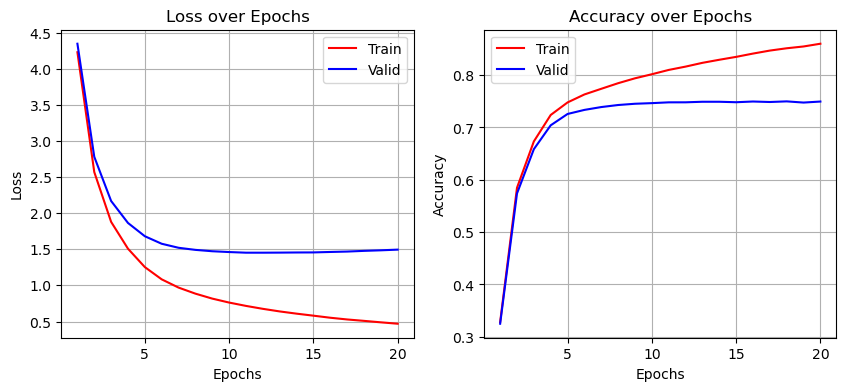

In [57]:
# show plot

TH = len(train_history['Loss'])
plt.figure(figsize=(10, 4))
# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, TH+1), train_history['Loss'], 'r-', label='Train')
plt.plot(range(1, TH+1), valid_history['Loss'], 'b-', label='Valid')
plt.grid()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, TH+1), train_history['Acc'], 'r-', label='Train')
plt.plot(range(1, TH+1), valid_history['Acc'], 'b-', label='Valid')
plt.grid()
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#### 모델 로드

In [58]:
# 모델 로드
model.load_state_dict(torch.load('best_model_okt.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluation(model, valid_dataloader, loss_function, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')


Best model validation loss: 1.4527
Best model validation accuracy: 0.7481


In [63]:
print(tar_vocab['<sos>'])
print(tar_vocab['<eos>'])


6214
3514


#### seq2seq 번역기 동작시키기

In [64]:
index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_vocab['<sos>'] and encoded_word != tar_vocab['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence


In [ ]:
print(encoder_input_test[25])
print(decoder_input_test[25])
print(decoder_target_test[25])

In [65]:
def decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, max_output_len, int_to_src_token, int_to_tar_token):
    encoder_inputs = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

    # 인코더의 초기 상태 설정
    # hidden, cell = model.encoder(encoder_inputs)
    hidden = model.encoder(encoder_inputs)
    

    # 시작 토큰 <sos>을 디코더의 첫 입력으로 설정
    # unsqueeze(0)는 배치 차원을 추가하기 위함.
    decoder_input = torch.tensor([6214], dtype=torch.long).unsqueeze(0).to(device)

    decoded_tokens = []

    # for문을 도는 것 == 디코더의 각 시점
    for _ in range(max_output_len):
        output, hidden = model.decoder(decoder_input, hidden)

        # 소프트맥스 회귀를 수행. 예측 단어의 인덱스
        output_token = output.argmax(dim=-1).item()

        # 종료 토큰 <eos>
        if output_token == 3514:
            break

        # 각 시점의 단어(정수)는 decoded_tokens에 누적하였다가 최종 번역 시퀀스로 리턴합니다.
        decoded_tokens.append(output_token)

        # 현재 시점의 예측. 다음 시점의 입력으로 사용된다.
        decoder_input = torch.tensor([output_token], dtype=torch.long).unsqueeze(0).to(device)

    return ' '.join(int_to_tar_token[token] for token in decoded_tokens)


In [ ]:
encoder_input_test[1]

In [66]:
#### 번역 모델 결과 확인
for seq_index in [3, 50, 100, 304, 1001]:
  input_seq = encoder_input_test[seq_index]
  translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 100, index_to_src, index_to_tar)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",translated_text)
  print("-"*50)


입력문장 : 수박 은 큰 게 맛있다고 하는데 참외 는 작은 게 맛있는 거 맛있다고 작은 게 맛있는 거 아닙니까 
정답문장 : 수박 은 큰 기 맛있다고 카는데 참외 는 작은 게 맛있는 거 마시따꼬 작은 기 맛있는 거 아 입 니까 
번역문장 : 수박 은 큰 게 맛있다고 하는디 참외 는 작은 게 맛있는 건교
--------------------------------------------------
입력문장 : 지금 은 안개 도 짙고 파도 가 높아서 배 가 전혀 못 다닌다고 하더라고요 
정답문장 : 지금 은 안개 도 짙고 파도 가 높아서 배 가 전혀 못 다닌다고 하더라 꼬 요 
번역문장 : 지금 안개 도 짙고 파도 가 노파 가 배 가 만괴 못 댕 긴다고 하 대 예
--------------------------------------------------
입력문장 : 요즘 날씨 가 가물어서 농사 도 못 짓고 계속 집 에만 있어서 정말 답답해 
정답문장 : 오 새 날씨 가 가물어서 농사 도 몬 짓고 계속 집 에만 이 쓰이께네 정말 답답해 
번역문장 : 요새 날씨 가 가물어서 농사 도 못 짓고 계속 집 에만 이 쓰니꺼네 정말 답 땁네
--------------------------------------------------
입력문장 : 배추 한 포기 키우는 것 도 이렇게 힘든데 어머니 는 어떻게 평생 농사 를 짓고 사셨을까 
정답문장 : 배치 한 포기 키우는 것 도 이러쿠럼 힘든디 어 모이는 우 예 펭생 농새 를 짓고 사라 쓸라 
번역문장 : 배치 한 포기 키우는 것 도 이러쿠럼 힘든디 어무이 는 우 예 평생 농사 를 짓고 사라 쓸라
--------------------------------------------------
입력문장 : 지금 안개 도 짙고 파도 가 높아서 배 가 전혀 못 다닌다고 하더라고요 
정답문장 : 지금 안기도 짙고 파도 가 노파 가 배 가 만괴 몬 땡긴다 꼬 하 대 예 
번역문장 : 지금 안개 도 짙고 파도 가 노파 가 배 가 만괴 못 댕 긴다고 하

In [68]:
#### 번역 모델 결과 확인
for seq_index in [3, 50, 100, 304, 1004]:
  input_seq = encoder_input_test[seq_index]
  translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 100, index_to_src, index_to_tar)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("번역문장 :",translated_text)
  print("-"*50)

입력문장 : 수박 은 큰 게 맛있다고 하는데 참외 는 작은 게 맛있는 거 맛있다고 작은 게 맛있는 거 아닙니까 
번역문장 : 수박 은 큰 게 맛있다고 하는디 참외 는 작은 게 맛있는 건교
--------------------------------------------------
입력문장 : 지금 은 안개 도 짙고 파도 가 높아서 배 가 전혀 못 다닌다고 하더라고요 
번역문장 : 지금 안개 도 짙고 파도 가 노파 가 배 가 만괴 못 댕 긴다고 하 대 예
--------------------------------------------------
입력문장 : 요즘 날씨 가 가물어서 농사 도 못 짓고 계속 집 에만 있어서 정말 답답해 
번역문장 : 요새 날씨 가 가물어서 농사 도 못 짓고 계속 집 에만 이 쓰니꺼네 정말 답 땁네
--------------------------------------------------
입력문장 : 배추 한 포기 키우는 것 도 이렇게 힘든데 어머니 는 어떻게 평생 농사 를 짓고 사셨을까 
번역문장 : 배치 한 포기 키우는 것 도 이러쿠럼 힘든디 어무이 는 우 예 평생 농사 를 짓고 사라 쓸라
--------------------------------------------------
입력문장 : 여기는 시골 이라 교통 이 좀 불편한데 공기 도 깨끗하고 경치 가 참 좋아요 
번역문장 : 여기는 시골 이라 교통 이 좀 불편한디 공기 도 깨 끔하고 갱 치가 참 조 아예
--------------------------------------------------
